In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs,nrow=4,normalize=True)
    npimgs = imgs.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [3]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img,features_d,4,2,1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d,features_d*2,4,2,1),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*2,features_d*4,4,2,1),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*4,features_d*8,4,2,1),
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*8,1,4,2,0),
            nn.Sigmoid()
    
        )
    def forward(self,x):
        return self.net(x)

In [4]:
class Generator(nn.Module):
    def __init__(self,channels_noise,channels_img,features_g):
        super(Generator,self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(channels_noise,features_g*16,4,1,0),
            nn.BatchNorm2d(features_g*16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*16,features_g*8,4,2,1),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*8,features_g*4,4,2,1),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*4,features_g*2,4,2,1),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*2,channels_img,4,2,1),       
            nn.Tanh()
        )
        
    def forward(self,x):
        return self.net(x)

In [34]:
img_size = 64
batch_size = 100
noise_channel = 100
img_channel = 3
features_d = 16
features_g = 16
EPOCHS = 100
data_set = torchvision.datasets.FashionMNIST(root='.',download=True,train=True,transform=T.Compose([
    T.Resize(64),
    T.ToTensor(),
]))
data_set = torchvision.datasets.ImageFolder(
    root = 'Pokemon/',
    transform=T.Compose([
    T.Resize(64),
    T.ToTensor(),
])  
)

trainloader = DataLoader(data_set,batch_size=batch_size)

In [35]:
G = Generator(noise_channel,img_channel,features_g).cuda()
D = Discriminator(img_channel,features_d).cuda()
G_opt = optim.Adam(G.parameters(),lr=2e-4,betas=(0.5,0.999))
D_opt = optim.Adam(D.parameters(),lr=2e-4,betas=(0.5,0.999))
const_noise = torch.randn(batch_size,noise_channel,1,1)
criterion = nn.BCELoss()
writer_fake = SummaryWriter('./DCGAN/poke')

In [ ]:
for epochs in tqdm(range(EPOCHS)):
    curr_batch = 0
    for data,label in trainloader:
        curr_batch +=1
        data = data.cuda()
        
        real_label = (torch.ones(batch_size)*0.9).cuda()
        fake_label = (torch.ones(batch_size)*0.1).cuda()        

        noise = torch.randn(batch_size,noise_channel,1,1).cuda()
        
        D_real = D(data)
        D_fake = D(G(noise).detach()).reshape(-1)
        
        D_real_loss = criterion(D_real,real_label)
        D_fake_loss = criterion(D_fake,fake_label)
        
        D_loss = D_real_loss + D_fake_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        G_fake = D(G(noise)).reshape(-1)
        label = torch.ones(batch_size).cuda()
        G_loss = criterion(G_fake,label)
        
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        if curr_batch%4 == 0:
            with torch.no_grad():
                fake_img = G(const_noise.cuda())
                real_img_grid = torchvision.utils.make_grid(data[:16],nrow=10,normalize=True)
                fake_img_grid = torchvision.utils.make_grid(fake_img[:16],nrow=10,normalize=True)
                writer_fake.add_image('Pokemon',fake_img_grid,epochs)                

 71%|███████   | 71/100 [02:56<01:12,  2.50s/it]

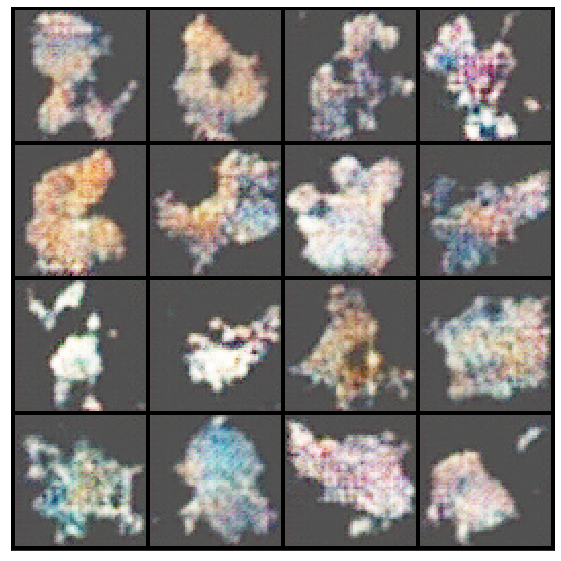

In [45]:
noise = torch.randn(16,100,1,1)
sample = G(noise.cuda())

imshow(sample.detach().cpu())

In [ ]:
sample.shape

In [ ]:
import pickle
state_dict = G.state_dict
with open('pokegen100DCGAN.h5','wb') as f:
    pickle.dump(state_dict,f)